In [1]:
easy_sample = (
    "Alice dropped her phone. She picked it up and smiled. "
    "Bob said he would help her later."
)

sample = (
    "Dr. Glenn Tyler (Elvis Presley), a childish 25-year old, gets into a fight with and badly injures his drunken brother. A court releases him on probation into the care of his uncle in a small town, appointing Irene Sperry (Hope Lange) to give him psychological counselling. Marked as a trouble-maker, he is falsely suspected of various misdemeanors including an affair with Irene. Eventually shown to be innocent, he leaves to go to college and become a writer."
)

In [2]:
from preprocess import preprocess
import json

out = preprocess(sample)
print(json.dumps(out["sentences"], indent=2, ensure_ascii=False))
doc = out["doc"]

/home/Spotted/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[
  "Dr. Glenn Tyler (Elvis Presley), a childish 25-year old, gets into a fight with and badly injures his drunken brother.",
  "A court releases him on probation into the care of his uncle in a small town, appointing Irene Sperry (Hope Lange) to give him psychological counselling.",
  "Marked as a trouble-maker, he is falsely suspected of various misdemeanors including an affair with Irene.",
  "Eventually shown to be innocent, he leaves to go to college and become a writer."
]


In [3]:
import spacy
from extraction import detect_entities, detect_events, create_narrative_segment, merge_narrative_segments

    
nlp = spacy.load("en_core_web_sm")
graph = None
segs = []
for sentence in out["sentences"]:
    print(f"- {sentence}")
    doc = nlp(sentence)
    ents = detect_entities(doc)
    evs = detect_events(doc)
    curr_seg_nodes, graph = create_narrative_segment(ents, evs, graph=graph)
    segs.append({"nodes": curr_seg_nodes, "graph": graph})
    print(f"  Entities: {len(ents)}, Events: {len(evs)}")
    print(f"  Entities: {ents}")
    print(f"  Events: {evs}")
    print("--------")

- Dr. Glenn Tyler (Elvis Presley), a childish 25-year old, gets into a fight with and badly injures his drunken brother.
  Entities: 3, Events: 3
  Entities: [{'id': 'fc161c88-4b4b-4f93-9600-9e292edb2a4a', 'text': 'Glenn Tyler', 'label': 'PERSON', 'start': 4, 'end': 15}, {'id': 'ab86ffc1-1790-42b5-bd21-83310e943407', 'text': 'Elvis Presley', 'label': 'PERSON', 'start': 17, 'end': 30}, {'id': '69ef1a65-eb9f-46cf-827b-144ffae14c15', 'text': '25-year old', 'label': 'DATE', 'start': 44, 'end': 55}]
  Events: [{'id': '7c7f59b3-0499-4867-9dfe-aa2eb6929b21', 'text': 'Dr. Glenn Tyler (Elvis Presley), a childish 25-year old, gets into a fight with and badly injures his drunken brother.', 'lemma': 'get', 'start': 0, 'end': 118, 'subject_texts': ['Tyler'], 'object_texts': [], 'sentence': 'Dr. Glenn Tyler (Elvis Presley), a childish 25-year old, gets into a fight with and badly injures his drunken brother.'}, {'id': '5aea5515-dd86-4482-a075-7a603b52f7fd', 'text': 'a fight with', 'lemma': 'fight', 

In [4]:
for text in ents:
    print("Entity Text:", text["text"])
    print(text["label"])
    print("---")

In [5]:
for text in evs:
    print("Event Text:", text["text"])
    print("Subject Texts:", text["subject_texts"])
    print("Object Texts:", text["object_texts"])
    print("---")

Event Text: Eventually shown to be innocent
Subject Texts: []
Object Texts: []
---
Event Text: Eventually shown to be innocent, he leaves to go to college and become a writer.
Subject Texts: ['he']
Object Texts: []
---
Event Text: to go to college and become a writer
Subject Texts: []
Object Texts: []
---
Event Text: become a writer
Subject Texts: []
Object Texts: []
---


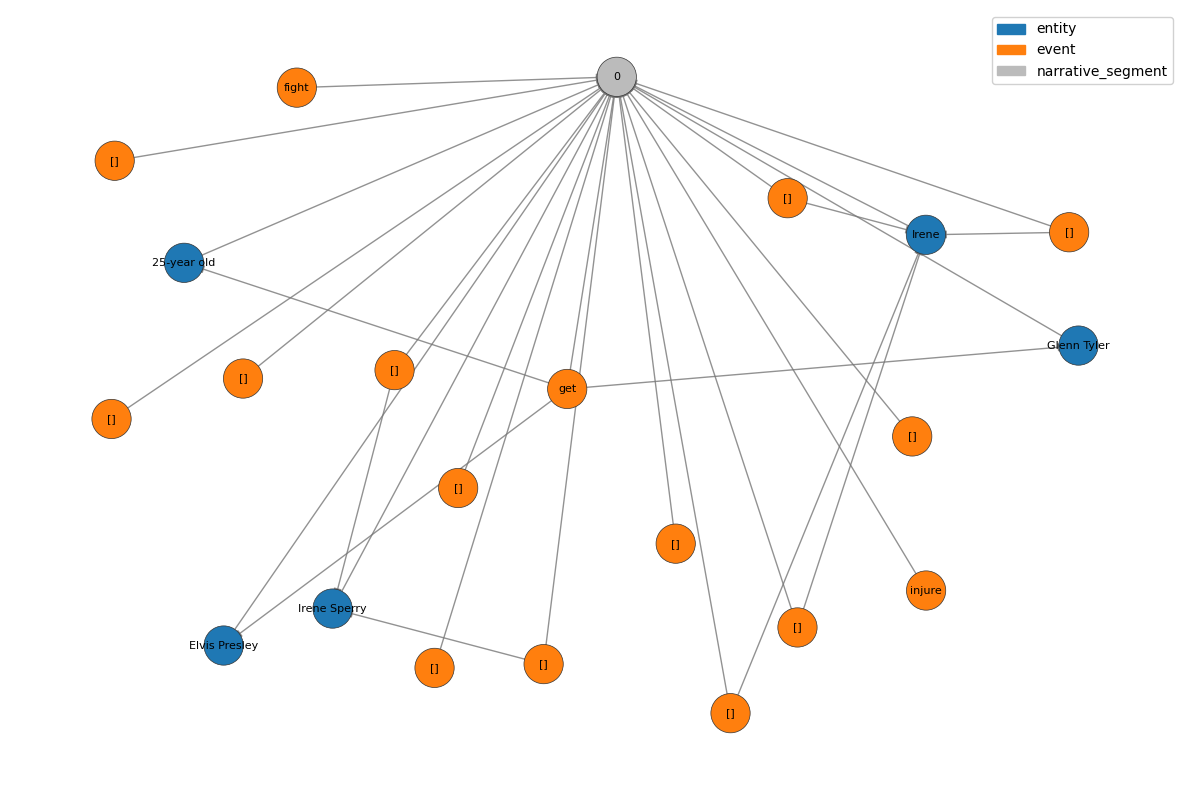

{0: array([0.10124065, 0.91756718]),
 'fc161c88-4b4b-4f93-9600-9e292edb2a4a': array([1.        , 0.18942386]),
 'ab86ffc1-1790-42b5-bd21-83310e943407': array([-0.6639298 , -0.62323448]),
 '69ef1a65-eb9f-46cf-827b-144ffae14c15': array([-0.74100996,  0.41367183]),
 '7c7f59b3-0499-4867-9dfe-aa2eb6929b21': array([0.00480716, 0.07189908]),
 '5aea5515-dd86-4482-a075-7a603b52f7fd': array([-0.52148356,  0.8882782 ]),
 '2e8b5d5b-c89d-4d6a-a7fd-aefe5c101155': array([ 0.70340489, -0.47421396]),
 'afca6b9d-6d2b-4928-84ae-24a5966df0ec': array([-0.45195642, -0.5231117 ]),
 '53b91e0e-22ac-467d-b3ba-2a56e8d7c01d': array([-0.33131467,  0.12292903]),
 '9ff40738-2ef3-4c9b-99fd-8d1beed3534f': array([ 0.21596882, -0.34723144]),
 '1fa1b474-858b-4ccf-ad2a-74144dd9eb46': array([-0.04113528, -0.67359131]),
 '68480e14-1975-403a-87bb-b154504d15cf': array([-0.20746112, -0.19651771]),
 '78b53cc3-cc9b-4d0e-963a-08269a3b44f9': array([0.70303127, 0.48950534]),
 'd7d1a97e-7973-401e-befc-d56f462acd02': array([-0.626222

In [7]:
from utils import visualize_graph
curr_nodes, curr_graph = segs[0]["nodes"], segs[0]["graph"]
visualize_graph(curr_graph, nodes=curr_nodes)